<a href="https://colab.research.google.com/github/taehyeonk/pre-onboarding_project/blob/seondo/5%ED%8C%80_%EA%B8%B0%EC%97%85_%EA%B3%BC%EC%A0%9C_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [2]:
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
dataset = load_dataset("klue", "sts")

Downloading:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [87]:
# dataset train / validation 분리
train_df = pd.DataFrame(dataset['train'])
valid_df = pd.DataFrame(dataset['validation'])

In [88]:
## Pandas row, column 표기 제한 옵션
# pd.describe_option() # pandas 출력 옵션 확인
# pd.set_option('display.max_colwidth', None) # Column 표현 제한 해제, default 50
# pd.set_option('display.max_rows', None) # Row 표현 제한 100개까지, default 100

In [94]:
train_df.head(3)

,guid,source,sentence1,sentence2,labels
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714..."
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe..."
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.3, 'real-label': 0.333333333333333..."


In [89]:
# Train Data 불용어 전처리 

# \xa0 삭제
train_df['sentence1'] = train_df['sentence1'].str.replace('\xa0','') 
train_df['sentence2'] = train_df['sentence2'].str.replace('\xa0','') 

# 괄호 + 괄호안 내용 삭제
train_df['sentence1'] = train_df['sentence1'].str.replace('\(.*\)', '', regex=True)
train_df['sentence2'] = train_df['sentence2'].str.replace('\(.*\)', '', regex=True) 

# 화살표 삭제(보류)
# train_df['sentence1'] = train_df['sentence1'].str.replace('→', ' ', regex=True)
# train_df['sentence2'] = train_df['sentence2'].str.replace('→', ' ', regex=True)
# train_df[train_df['sentence1'].str.contains('→')] # 화살표 포함 문장 확인

In [90]:
# Validation Data 불용어 전처리 

# \xa0 삭제
valid_df['sentence1'] = valid_df['sentence1'].str.replace('\xa0','')  
valid_df['sentence2'] = valid_df['sentence2'].str.replace('\xa0','') 

# 괄호 + 괄호안 내용 삭제
valid_df['sentence1'] = valid_df['sentence1'].str.replace('\(.*\)', '', regex=True)
valid_df['sentence2'] = valid_df['sentence2'].str.replace('\(.*\)', '', regex=True) 

# 화살표 삭제(보류)
# valid_df['sentence1'] = valid_df['sentence1'].str.replace('→', ' ', regex=True)
# valid_df['sentence2'] = valid_df['sentence2'].str.replace('→', ' ', regex=True)
# valid_df[valid_df['sentence1'].str.contains('→')] # 화살표 포함 문장 확인

In [95]:
# Train/Validation labels → real-label로 변경(binary-label, real-label 미사용)
train_df['labels'] = train_df['labels'].apply(lambda x : x['real-label'])
valid_df['labels'] = valid_df['labels'].apply(lambda x : x['real-label'])

In [96]:
# 결측치 여부 확인
print(f'Train 데이터 수 : {len(train_df)}개, \n결측치 :\n{train_df.isnull().sum()}', '\n')
print(f'Validation 데이터 수 : {len(valid_df)}개, \n결측치 :\n{valid_df.isnull().sum()}')

Train 데이터 수 : 11668개, 
결측치 :
guid         0
source       0
sentence1    0
sentence2    0
labels       0
dtype: int64 

Validation 데이터 수 : 519개, 
결측치 :
guid         0
source       0
sentence1    0
sentence2    0
labels       0
dtype: int64


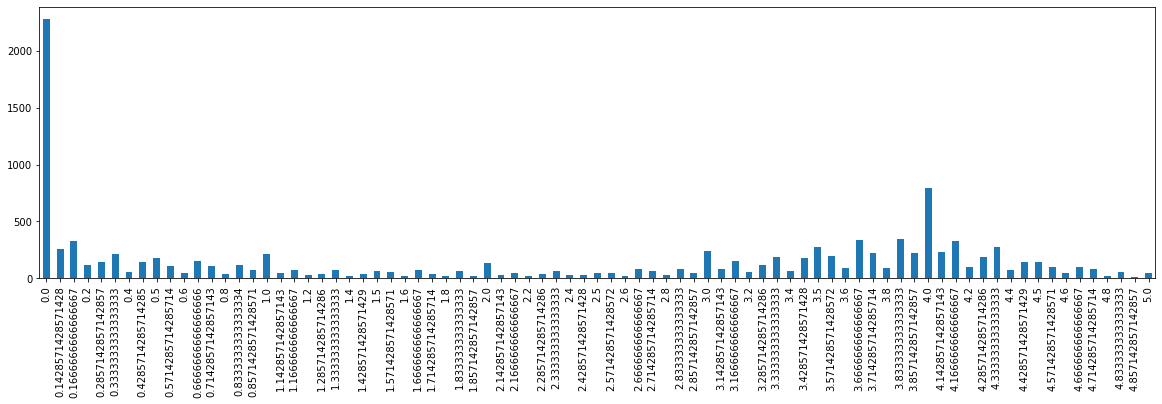

In [105]:
# Train Data label 분포
train_df['labels'].value_counts().sort_index().plot(kind='bar', figsize=(20,5))

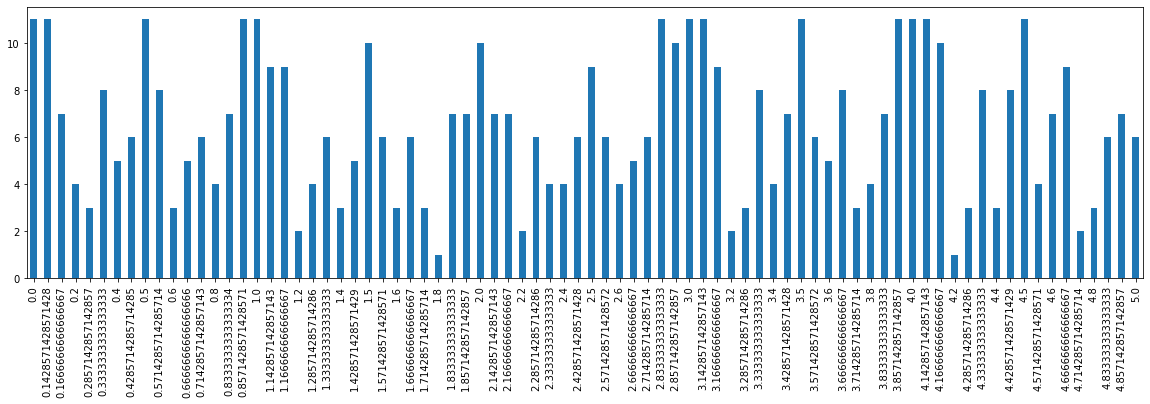

In [106]:
# Validation Data label 분포
valid_df['labels'].value_counts().sort_index().plot(kind='bar', figsize=(20,5))

In [107]:
# sentence 1,2 병합
sentence1_temp = train_df['sentence1'].tolist()
sentence2_temp = train_df['sentence2'].tolist()
sentence_list = list(zip(sentence1_temp, sentence2_temp))
sentence_series = pd.Series(sentence_list)
train_df['sentence'] = sentence_series
train_df.head(3)

,guid,source,sentence1,sentence2,labels,sentence
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.714286,"(숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다., 숙박시설의 위치는 쉽..."
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을한 것은 아산 뿐만이 아니었다.,0.000000,(위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다....
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333,"(회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘., 사람들이..."


In [108]:
class BasicDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of float
    """
    def __init__(self, input_data:list, target_data:list) :
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [109]:
train_dataset = BasicDataset(train_df['sentence'].tolist(),train_df['labels'].tolist())

In [110]:
len(train_dataset)

11668

In [111]:
train_dataset[0]

(('숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
  '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.'),
 3.714285714285714)

In [119]:
# train 데이터를 train, test로 분리(float -> int 타입 변경으로 차이가 발생한 경우 남은 차이를 train으로 추가)
n_train = int(len(train_df) * 0.8)
n_test = int(len(train_df) * 0.2)
diff_value = len(train_df) - (n_train + n_test)
if diff_value != 0:
    n_train += diff_value

train_dataset, test_dataset = random_split(train_dataset, [n_train, n_test])

In [120]:
print(len(train_dataset), len(test_dataset))

9335 2333


In [ ]:
def custom_collate_fn(batch):
    """
    - batch: list of tuples (input_data(string), target_data(int))
    
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    (input, target) 튜플 형태를 반환.
    """
    input_list, target_list = [], []
    
    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer_bert(
        input_list,
        add_special_tokens=True,
        padding="longest",  # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label
    